#  <span style="font-family: Latin Modern Roman; font-size: 35px; font-weight: bold;"> Project 2. Unsupervised Learning with Recommender Systems </span>

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 1. Introduction </span>
<div style="text-align: justify;">

Recommender systems are capable of providing consumers with tailored suggestions, pointing them toward products they are likely to appreciate but would not have discovered on their own, by examining trends in their behavior, interests, and interactions. These systems are essential for raising engagement in the world of music streaming and discovery services such as Last.fm. In order to match listeners with music that suits their likes, the aim of this project is to construct a **recommender system** that combs through the enormous database of songs, artists, and genres based on information of listener history utilizing detailed user interactions and artist information to predict and influence future listens.

USE COLLABORATIVE FILTERING:




USE IMPLICIT:


For an understanding of users' listening likes and behaviors in this context, listening counts are an essential measure. In contrast to explicit ratings, where users directly rate their preferences on a scale, listening counts are an example of **Implicit Feedback**. By recording the frequency of engagement with various artists, they offer insights into user behavior, but they do not indicate the level of preference. This type of data offers valuable insights into user behavior—indicating preference through the frequency of interactions with artists. A high listening count implies a user's affinity for an artist, while the absence of listening activity doesn't necessarily indicate dislike it could simply mean the user has yet to discover the artist.

The combination of listening counts, artist popularity, user-generated tags, and the rich set of artist attributes in this dataset provides a comprehensive foundation for creating a music recommender system making use of complex models capable of interpreting these implicit signals:

INCLUDE COLLAB FILTERING WITH MEMORY BASED

- **Bayesian Personalized Ranking (BPR)**:

- **Weighted Matrix Factorization (WFM)**:

- **Factorization Machines (FM)**:

</div>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 2. Exploratory Data Analysis </span>

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> Data Tables </span>
<div style="text-align: justify;">

**Artists Data:**

This table contains information about music artists listened to and tagged by the users.

* `artistID`: unique identifier for each artist.

* `name`: name of the artist.

* `freq`: how often the artist appears in the dataset.

* `listeners`: number of users who have listened to the artist.

**Tags Data:**

This table contains the set of tags or genres available.

* `tagID`: unique identifier for each tag.

* `tagValue`: name of the tag, which can represent a genre, mood, era, or any other music-related attribute.

**User-Artist Data Data:**

This table captures which artists users have listened to, including a count of listening events.

* `userID`: unique identifier for each user.

* `artistID`: artist listened to by the user.

* `weight`: count of how many times the user has listened to the artist, indicative of the user's preference strength for that artist.

**User-Tagged Artists Data**

This table contains the tags that users have assigned to artists, along with timestamps indicating when the tagging occurred.

* `userID`, `artistID`, `tagID`: identifiers linking users, artists, and tags.

* `day`, `month`, `year`: date when the tag was assigned, providing temporal context.


In [1]:
import pandas as pd 

artists = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


In [2]:
print("Artists Data:")
print(artists.head())

Artists Data:
   artistID            name  freq  listeners
0        89       Lady Gaga   611    3798959
1       289  Britney Spears   522    3243214
2       288         Rihanna   484    4542147
3       227     The Beatles   480    3658694
4       300      Katy Perry   473    3721531


In [3]:
print("User-Tagged Artists Data:")
print(user_tag_artist.head())

User-Tagged Artists Data:
   userID  artistID  tagID  day  month  year
0       2        52     13    1      4  2009
1       2        52     15    1      4  2009
2       2        52     18    1      4  2009
3       2        52     21    1      4  2009
4       2        52     41    1      4  2009


In [4]:
print("Tags Data:")
print(tags.head())

Tags Data:
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


In [5]:
print("Users Data:")
print(users.head())

Users Data:
   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983


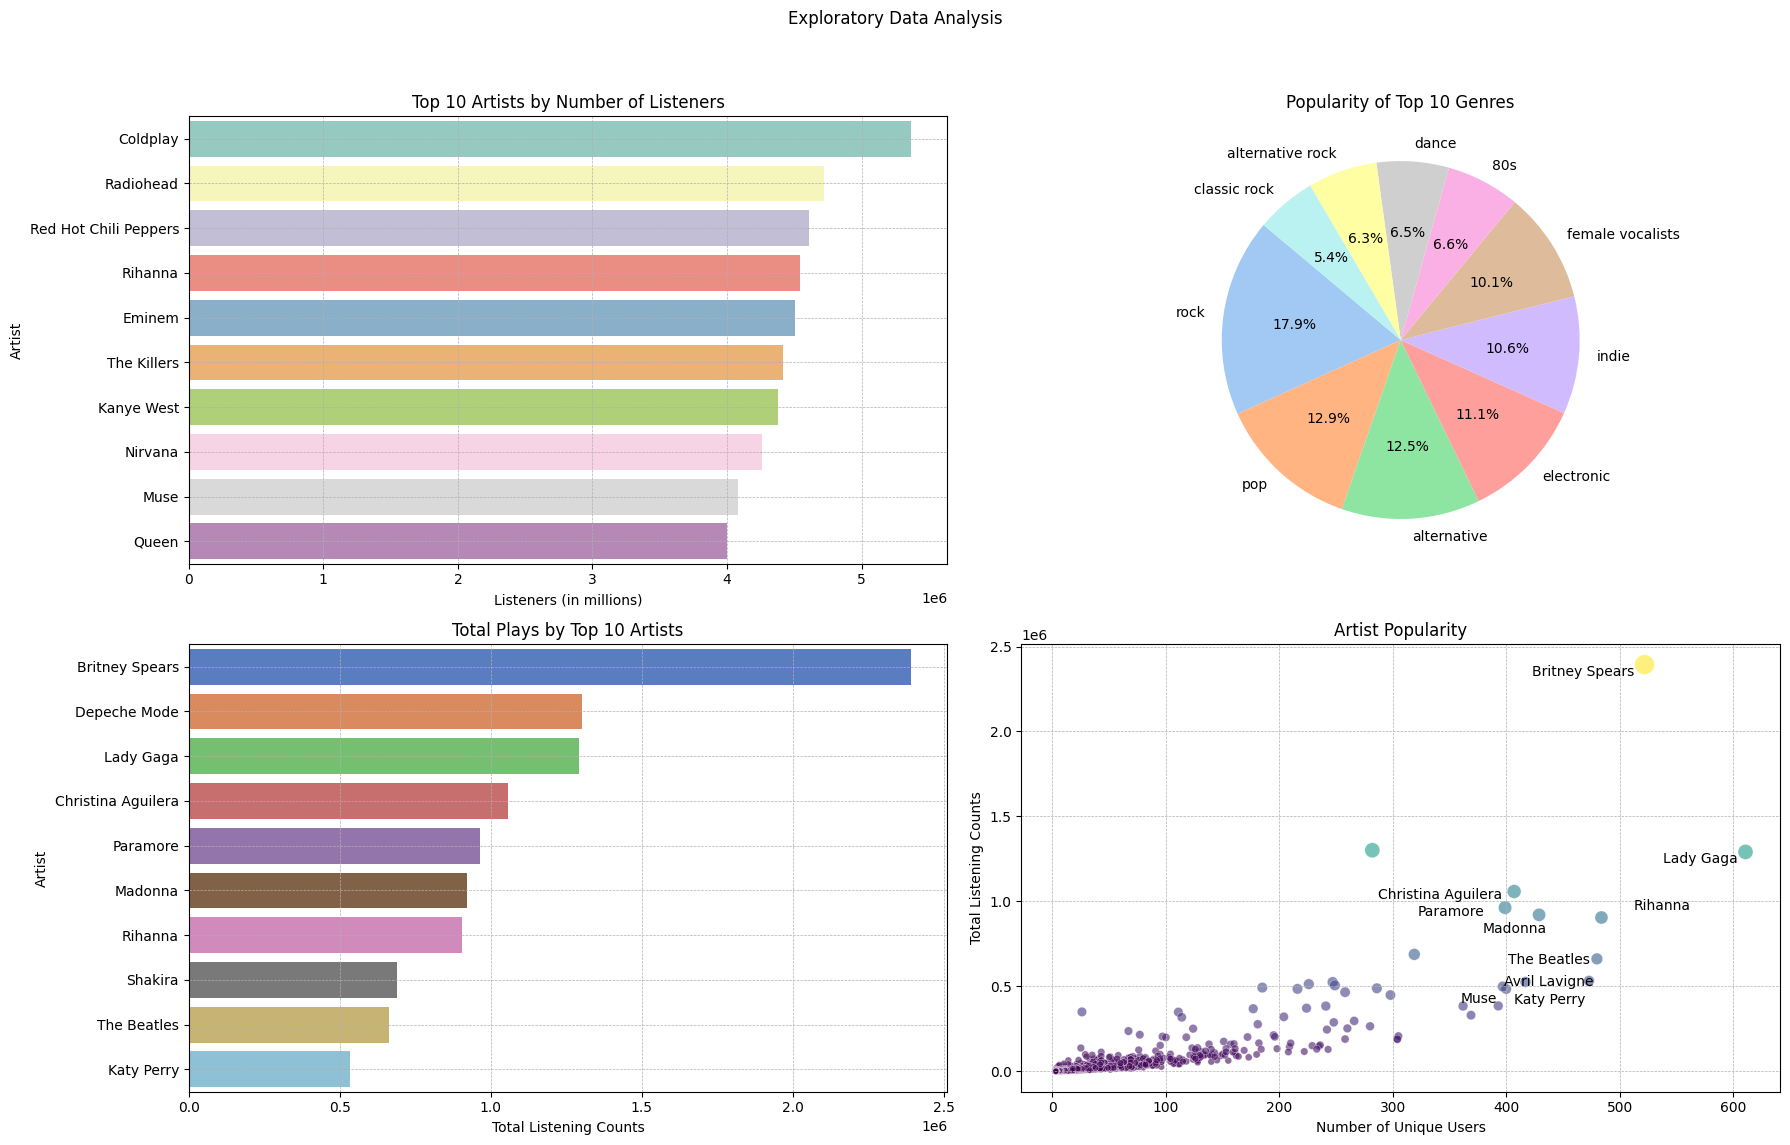

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import warnings

warnings.filterwarnings("ignore")

# Subplot area
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
fig.suptitle('Exploratory Data Analysis')

# Popularity of Artists
top_artists = artists.sort_values(by = 'listeners', ascending = False).head(10)
sns.barplot(x = 'listeners', y = 'name', data = top_artists,  ax = axes[0, 0], palette = 'Set3')
axes[0, 0].set_title('Top 10 Artists by Number of Listeners')
axes[0, 0].set_xlabel('Listeners (in millions)')
axes[0, 0].set_ylabel('Artist')
axes[0, 0].grid(True, which = "both", ls = "--", linewidth = 0.5)

# Popularity of Genres
genre_counts = user_tag_artist.groupby('tagID').size().sort_values(ascending=False).head(10)
top_genres = pd.merge(genre_counts.reset_index(), tags, how = 'left', on = 'tagID')
axes[0, 1].pie(top_genres[0], labels = top_genres['tagValue'], autopct = '%1.1f%%', startangle = 140, colors = sns.color_palette('pastel'))
axes[0, 1].set_title('Popularity of Top 10 Genres')

# Total Plays by Artist (Listening Counts)
total_plays_by_artist = users.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(10)
top_artists_by_plays = pd.merge(total_plays_by_artist.reset_index(), artists, on = 'artistID')
sns.barplot(x = 'weight', y = 'name', data=top_artists_by_plays,  ax = axes[1, 0], palette = 'muted')
axes[1, 0].set_title('Total Plays by Top 10 Artists')
axes[1, 0].set_xlabel('Total Listening Counts')
axes[1, 0].set_ylabel('Artist')
axes[1, 0].grid(True, which = "both", ls = "--", linewidth = 0.5)

# Identifying the top 10 artists by popularity (considering both unique users and total listening counts)
artist_popularity = users.groupby('artistID').agg({'userID': pd.Series.nunique, 'weight': 'sum'})
artist_popularity = artist_popularity.merge(artists[['artistID', 'name']], on='artistID')
top_artists_by_popularity = artist_popularity.sort_values(by = ['userID', 'weight'], ascending = False).head(10)
sns.scatterplot(x = 'userID', y = 'weight', data = artist_popularity, size = 'weight', hue = 'weight', legend = False, alpha = 0.6, sizes = (20, 200),  ax = axes[1, 1], palette = 'viridis')
artist_names = []
for i, row in top_artists_by_popularity.iterrows():
    artist_names.append(plt.text(row['userID'], row['weight'], row['name']))
adjust_text(artist_names)
axes[1, 1].set_title('Artist Popularity')
axes[1, 1].set_xlabel('Number of Unique Users')
axes[1, 1].set_ylabel('Total Listening Counts')
axes[1, 1].grid(True, which = "both", ls = "--", linewidth = 0.5)

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()


## <span style="font-family: Latin Modern Roman; font-size: 20px; font-style: italic;"> Insights Gained from Initial Exploration </span>
<div style="text-align: justify;">

These visualizations offer a comprehensive picture of the popularity of different artists and genres within the dataset, as well as specific insights into the tastes and behavior of Last.fm users. Examining each graph in detail:

- **Top 10 Artists by Number of Listeners**: This barplot reveals the artists with the largest unique listener bases. The main takeaway from this is that these artists are popular with a wide range of user segments. The artists at the top of this list, like Coldplay, have effectively reached a large audience, which could make them excellent choices for broad-based recommendations. These artists are probably going to be well-liked by new listeners, based on their large listener numbers, which reflect a general popularity that goes beyond specialist interests.

- **Popularity of Top 10 Genres**: The most popular musical genres and characteristics are displayed in the genre popularity pie chart. Popular music genres on this chart, such pop, rock, and electronic music, are indicative of what most users in this streaming service like to listen to. It represents quite helpful information as it helps to figure out general musical trends, which makes it possible to provide suggestions based on genre that suit the tastes of most people. It also emphasizes how crucial tag-based categorization is for identifying user interests.

- **Total Plays by Top 10 Artists**: Artists with high listening counts demonstrate strong involvement as well as broad popularity when ranked by total plays. An artist like Britney Spears leading this chart suggests a dedicated fan base that listens to her music frequently. This distinction is important for recommendations since artists with a large number of plays may have a strong emotional connection with their audience and encourage return visits. Thus, suggests the possibility of fostering user loyalty and enduring interest. 

- **Artist Popularity**: This scatterplot combines the dimensions of unique listener counts and total plays to map out the landscape of artist popularity more comprehensively. It displays a range of artist profiles, from those with high unique users and total reproductions and to the ones that have lower listeners and total plays. Most importantly, it distinguishes between artists with a broad but perhaps shallower appeal (high unique users but lower plays per user) and those who, although having fewer listeners, induce high engagement (high plays but lower unique user counts). This perspective helps customize suggestions to match user preferences for breadth (new artists to discover) versus depth (artists they could get deeply engaged with).

</div>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 3. Collaborative Filtering</span>

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 3.1. Memory Based Approach</span>

<div style="text-align: justify;">
 
En Collaborative Filtering hay 2 approaches claves: Memory based approach y Model based approach. 
Memory Based Approach trata de encontrar usuarios similares basados en "cosine similarity" o "pearson correlation" y de ahí toma el weighted average de los ratings. 

 Existen dos tipos principales de algoritmos basados en vecindarios:

- **User Based**: (COMPARO USUARIOS) En este caso, las calificaciones proporcionadas por usuarios similares a un usuario objetivo A se utilizan para hacer recomendaciones para este usuario A. Las calificaciones predichas de A se calculan como los valores promedio ponderados de estas calificaciones del "grupo de pares" para cada ítem. Tenemos una matriz M(users)xN(items)= ratings matrix y eso es Rij. Clave antes de empezar es que yo quiero hacer un user based method entonces voy a hacerme filas y comparo las filas usuario1 y usuario2 (son vectores).

Imp: No se estandariza para no penalizar a un usuario, se normaliza. 


- **Item Based**: (COMPARO ITEMS) Para hacer recomendaciones para el ítem objetivo B, el primer paso es determinar un conjunto S de ítems que son más similares al ítem B. Luego, para predecir la calificación de cualquier usuario A para el ítem B, se determinan las calificaciones en el conjunto S, que están especificadas por A. El promedio ponderado de estas calificaciones se utiliza para calcular la calificación predicha del usuario A para el ítem B.

En user-based, tenemos el coeficiente de correlación de Pearson y cosine similarity. En cambio, en item-based tenemos también el adjusted cosine. 

</div>

In [7]:
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN
import pandas as pd
import numpy as np
from numpy import isnan
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
from cornac.models import ItemKNN
from cornac.metrics import RMSE

In [8]:
# ItemKNN methods
VERBOSE = False
K = 50  # Number of nearest neighbors

iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

In [9]:
SEED = 29

# Initialize RatioSplit
ratio_split = RatioSplit(data = users.to_numpy(), test_size = 0.1, seed = SEED, verbose = VERBOSE)

cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=[cornac.metrics.RMSE()],
).run()



TEST:
...
                       |      RMSE | Train (s) | Test (s)
---------------------- + --------- + --------- + --------
ItemKNN-Cosine         | 1281.3247 |    1.8543 |   0.3889
ItemKNN-Pearson        | 1233.8908 |    1.7712 |   0.3708
ItemKNN-Pearson-MC     | 1219.6881 |    1.7841 |   0.3932
ItemKNN-AdjustedCosine | 1223.6181 |    1.6604 |   0.4632



In [10]:
user_df = users.copy()  

user_df.columns = ["userID", "artistID", "weight"]

user_df.set_index("userID", inplace=True)

item_df = artists.copy() 

item_df.columns = ["artistID", "name", "freq", "listeners"]

item_df.set_index("artistID", inplace=True)


In [21]:
user_df.sort_values(by='userID', ascending=True)

,artistID,weight
userID,,
2,51,13883
2,78,2119
2,79,1990
2,80,1972
2,81,1948
...,...,...
2100,4271,2026
2100,4611,360
2100,4970,614


In [47]:
# User-item interaction matrix from the trained model
rating_mat = iknn_adjusted.train_set.matrix
# Dictionaries mapping the original user and item IDs to their respective indices in the interaction matrix
user_id2idx = iknn_adjusted.train_set.uid_map
item_id2idx = iknn_adjusted.train_set.iid_map
# Lists that allow mapping back from the internal user/item indices to their original IDs
user_idx2id = list(iknn_adjusted.train_set.user_ids)
item_idx2id = list(iknn_adjusted.train_set.item_ids)

TOPK = 5
UID = 2100  # El ID del usuario deseado; 
UIDX = user_id2idx.get(UID)

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

# Ratings between the selected user and all items
rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
print("Ratings:", rating_arr[top_rated_items])
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 2100
-------------------------
        artistID  weight
userID                  
2100           3     408
2100           6     404
2100          12    1253
2100          28     911
2100          47     305
2100         837     762
2100         841     553
2100        1109    1333
2100        1111    1062
2100        1134    1213
2100        1260    1459
2100        1276    1133
2100        1281     573
2100        2749     532
2100        2765     457
2100        2772     485
2100        2774     436
2100        3806     389
2100        4182     258
2100        4271    2026
2100        4611     360
2100        4970     614
2100        6258     403
2100        6658     731
2100        7918     289
2100        8320     284
2100        8322     650
2100        8323     456
2100        8324    1068
2100        8326     626
2100        8327     613
2100        8332     655
2100        8344     640
2100        8525     232
2100        8529     429
2100        8531     607
2100      

,name,freq,listeners
artistID,,,
1134,Agalloch,17,308395
12,Behemoth,19,400444
1109,Yann Tiersen,69,1359680
1260,Marduk,11,187525
4271,Burzum,19,357934


In [36]:
item_df.sort_values(by='artistID', ascending=True)

,name,freq,listeners
artistID,,,
1,MALICE MIZER,3,96960
2,Diary of Dreams,12,128342
3,Carpathian Forest,3,139909
6,Moonspell,10,335697
7,Marilyn Manson,133,2229885
...,...,...,...
16668,Danger Mouse and Sparklehorse,3,113046
16697,Birdman,3,1064265
16709,The Afters,3,172872


In [50]:
recommendations, scores = iknn_adjusted.rank(UIDX) #mejor el coseno ajustado para item
#coseno ajustado NO VALE PARA LAS FILAS!!!!!!!!!!!!!!!!!!!!!!!

# Assuming 'recommendations' contains the top recommended item indices from the model
top_recommended_ids = [item_idx2id[i] for i in recommendations[:TOPK]]

# Ensure only to include artistIDs that exist in item_df's index
existing_artist_ids = [id_ for id_ in top_recommended_ids if id_ in item_df.index]

# Retrieve information for existing artistIDs from item_df
if existing_artist_ids:
    recommended_items = item_df.loc[existing_artist_ids]
    print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
    print(recommended_items)
else:
    print(f"No valid recommendations found for user {UID}.")



TOP 5 RECOMMENDATIONS FOR USER 2100:
                   name  freq  listeners
artistID                                
12980     Anthony Green     3     160129


---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 4. Implicit Feedback</span>
<div style="text-align: justify;">
 
 La retroalimentación implícita (implicit feedback) en los sistemas de recomendación se refiere a entender las preferencias de los usuarios a través de su comportamiento, como clics o interacciones, en lugar de calificaciones explícitas. Por ejemplo, en un servicio de música como es este caso, el hecho de que un usuario escuche una canción puede indicar su preferencia por ella. Esta información se utiliza para mejorar las recomendaciones personalizadas. Y, es importante mencionar que en lugar de calificaciones, se utilizan matrices de adopción para representar las interacciones entre usuarios e ítems.
 
</div>

## <span style="font-family: Latin Modern Roman; font-size: 20px;"> 4.1. Bayesian Personalized Ranking (BPR) </span>

<div style="text-align: justify;">
 
 **Bayesian Personalized Ranking (BPR)** es un enfoque para hacer recomendaciones personalizadas, especialmente útil cuando no tenemos muchas calificaciones explícitas de los usuarios, sino más bien acciones implícitas como clics o visitas. En lugar de predecir una calificación específica para un artículo, BPR se centra en clasificar los artículos en función de la probabilidad de que a un usuario le guste uno más que otro. Utiliza una técnica de comparación de pares, donde se compara cada artículo que un usuario ha interactuado con aquellos que no ha visto. El objetivo es aprender a clasificar los artículos de manera que coincidan con las preferencias del usuario basadas en su historial de interacciones.

 El BPR tiene algunos parámetros importantes que debemos considerar:
 - k: controla la dimensión del espacio latente 
 - max_iter: define el número de iteraciones del procedimiento de Descenso de Gradiente Estocástico (SGD, por sus siglas en inglés).
 - learning_rate: controla el tamaño del paso α en las reglas de actualización de gradientes.
 - lambda_reg: controla la regularización L2 λ en la función objetivo.
 
</div>

## <span style="font-family: Latin Modern Roman; font-size: 20px;"> 4.2. Weighted Matrix Factorisation (WMF) </span>

<div style="text-align: justify;">
 
 **Weighted Matrix Factorization - WMF** es una técnica de aprendizaje automático utilizada en sistemas de recomendación. Se basa en descomponer una matriz de interacciones user-item en dos matrices más pequeñas de dimensiones reducidas, donde cada fila de estas matrices representa la "característica" del usuario o del elemento. La diferencia clave entre WMF y MF (Matrix Factorization) original es que WMF intenta predecir adopciones no observadas, mientras que MF las ignora durante el training. En otras palabras, WMF busca predecir las interacciones entre items y users, incluso si no se han observado, mientras que MF se enfoca únicamente en las interacciones observadas.
 Como resultado de esta diferencia, el modelo WMF está diseñado para clasificar elementos al ajustar adopciones binarias, mientras que el modelo MF original se centra en predecir las calificaciones explícitas. Si bien el modelo MF tiene la capacidad de predecir calificaciones con precisión (RMSE más bajo), el modelo WMF supera al MF en todas las métricas de clasificación enumeradas. Esto se debe a que WMF está específicamente diseñado para clasificar elementos en función de la probabilidad de adopción, lo que lo hace más adecuado para tareas de recomendación de ranking.
 
</div>

## <span style="font-family: Latin Modern Roman; font-size: 20px;"> 4.3. Matrix Factorisation (MF) </span>

<div style="text-align: justify;">
 
 **La factorización de matrices** es una técnica utilizada en sistemas de recomendación para descomponer una matriz de interacciones usuario-elemento en dos matrices más simples: una de características de usuarios y otra de características de elementos, como hemos mencionado antes. Estas matrices representan las preferencias latentes de los usuarios y las propiedades de los elementos. El objetivo es ajustar estas matrices de manera que su producto se aproxime lo más posible a la matriz original de interacciones. Esto permite predecir las interacciones entre usuarios y elementos no observadas previamente, lo que se utiliza para recomendar elementos a los usuarios.

 
</div>